In [10]:
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [11]:
# random Seed 42 to reproduce the same results everytime
tqdm.pandas()
pl.seed_everything(42)

Global seed set to 42


42

In [12]:
'''
INPUT: CSV file with one target column ie. Protein Activity or Enzyme Activity
'''
timestamp_column_name = "TimeStamp"
df = pd.read_csv("pi_dataCSV.csv", parse_dates=[timestamp_column_name])

In [13]:
# Get all the names of the batches that we are going to train on
batch_names = list(sorted(df.Batch.unique()))

for batch in tqdm(batch_names):
    # Get all the index values (from CSV) of a batch
    list_of_indexes = np.where(df['Batch'] == batch)
    # Put a 0 as the protein activity for the start of the experiement
    indx_to_put_zero = list_of_indexes[0][0]
    # Put a 0 so that interpolation is possible
    df.loc[indx_to_put_zero,'PA-MÎ¨ [Main Fermentor]'] = float(0)

# Interpolate the protein activity values
df['PA-MÎ¨ [Main Fermentor]'] = df['PA-MÎ¨ [Main Fermentor]'].interpolate()


100%|██████████| 81/81 [00:00<00:00, 794.13it/s]


In [14]:
# Create a new DataFrame that will hold only relavant data

'''
While training on new dataset change the column names and variables names
'''
rows = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
        batch = row.Batch,
        day_of_week = row.TimeStamp.dayofweek,
        day_of_month = row.TimeStamp.day, 
        week_of_year = row.TimeStamp.week,
        month = row.TimeStamp.month,

        # Change column names and variable names from here
        # if training on new dataset
        ph = row['pH-M [Main Fermentor]'],
        temperature = row['Temperature-M [Main Fermentor]'],
        airflow = row['AirFlow-M [Main Fermentor]'],
        dissolved_oxygen = row['DO-M [Main Fermentor]'],
        agitator = row['AgitatorSpeed-M [Main Fermentor]'],

        # Name of the target column we need to predict.
        enzyme_activity = row['PA-MÎ¨ [Main Fermentor]']
    )

    rows.append(row_data)

# New DataFrame only with important features
features_df = pd.DataFrame(rows)

# Allocate 90% to training and 10% to testing
training_size = int(len(batch_names) * 0.9)

# 90% of batch names will go for training and remaining for testing
training_batch_names = batch_names[:training_size]
testing_batch_names = batch_names[training_size+1:]
len(training_batch_names), len(testing_batch_names)
print(testing_batch_names)


  0%|          | 0/24146 [00:00<?, ?it/s]

100%|██████████| 24146/24146 [00:02<00:00, 10389.84it/s]


['PBX0163', 'PBX0164', 'PBX0165', 'PBX0166', 'PBX0167', 'PBX0168', 'PBX0168A', 'PBX0169']


In [15]:
# Create a Training and testing Dataframe
train_df = pd.DataFrame(columns=features_df.columns)
test_df = pd.DataFrame(columns=features_df.columns)

# Collect the data based on the training/testing batch names
for batch in training_batch_names:
    batch_data = features_df[features_df['batch'] == batch]
    train_df = pd.concat([train_df, batch_data], ignore_index=True)

len(train_df.batch.unique())

72

In [16]:
for batch in testing_batch_names:
    batch_data = features_df[features_df['batch'] == batch]
    test_df = pd.concat([test_df, batch_data], ignore_index=True)

len(test_df.batch.unique())

8

In [18]:
train_sequences = []
test_sequences = []

# Name of the target column 
target_column = 'enzyme_activity'

# Sequence of data that will be used for training and testing
sequence_length = 50

In [19]:
# Creating a dataframe with training/testing batchs
for batch in training_batch_names:

    batch_df = pd.DataFrame(train_df[train_df.batch == batch])
    # Deleting batch column because it can not be scaled
    # Not needed for training
    del batch_df['batch']

    # Scale the values within -1 , 1
    scaler = MinMaxScaler(feature_range=(-1,1))
    # Fit the data
    scaler.fit(batch_df)
    # convert the scaled data to a dataframe
    scaled_df = pd.DataFrame(
    scaler.transform(batch_df),
    index = batch_df.index,
    columns=batch_df.columns
    )

    # create sequences 
    ''' 
    every sequence is a list with 2 columns:
    col 1: Sequence data from the dataframe
    col 2: target value
    output: n number of sequences
    sequence [ 
         [ dataframe sequence ]
         [ target value for the above sequence ],
    ]
    '''
    data_size = len(scaled_df)
    for i in tqdm(range(data_size - sequence_length)):
        sequence = scaled_df[i:i+sequence_length]
        label_position = i + sequence_length
        label = scaled_df.iloc[label_position][target_column]
        train_sequences.append((sequence, label))


# Create sequences for testing batches
for batch in testing_batch_names:
    batch_df = pd.DataFrame(test_df[test_df.batch == batch])
    del batch_df['batch']
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(batch_df)

    scaled_df = pd.DataFrame(
    scaler.transform(batch_df),
    index = batch_df.index,
    columns=batch_df.columns
    )

    data_size = len(scaled_df)
    sequence_l = 0
    for i in range(data_size - sequence_length):
        sequence = scaled_df[i:i+sequence_length]
        label_position = i + sequence_length
        label = scaled_df.iloc[label_position][target_column]
        test_sequences.append((sequence, label))



  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 16667.34it/s]


In [20]:
print(len(train_sequences))
print(len(test_sequences))


17839
2008


In [144]:
# Pytorch Dataset Class to create dataset objects
class Fermentation_dataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

In [145]:
# Pytorch-lightning data module class to utilize pl-lightning training functions

'''
NOTE: If the execution seems to be stuck then try changing the values of num_workers (0,1,2,3..)
'''
class FermentaionDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size = 8):
        super().__init__()
        self.train_sequence = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = Fermentation_dataset(self.train_sequence)
        self.test_dataset = Fermentation_dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )   

In [146]:
N_EPOCHS = 5
BATCH_SIZE = 32

# Create a pl-lightning data module  
data_module = FermentaionDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

# Looking if the dataloaders are parsing data properly or not
for i in data_module.train_dataloader():
    print(i['sequence'].shape)
    print(i['label'].shape)
    break

torch.Size([32, 50, 10])
torch.Size([32])


In [147]:
# Create a pytorch LSTM model 
class EnzymePredictionModel(nn.Module):
    
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True, 
            num_layers = n_layers,
            dropout = 0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)


    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [148]:
# A pl-lightning module for loss calculations and to check predictions

''' 
LOSS: MSE 
Optimizer : Adam

'''
class EnzymePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()

        self.model = EnzymePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [149]:
# Create the pl-lightning object for prediction
# pl-lightning provides methods to calculate loss and accuracy 
model = EnzymePredictor(n_features=batch_df.shape[1])

In [150]:
''' 
create a checkpoint that will save the best model
this will also create checkpoint for model retraining 
'''
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename='best-checkpoint',
    save_top_k= 1,
    verbose=True,
    monitor='validation_loss',
    mode = 'min'
)

# Create log files for tensorboard visualization 
logger = TensorBoardLogger('lightning_logs', name='btc-price')

# Stop the training if there is no progress in validation loss
early_stopping_callback = EarlyStopping(monitor='validation_loss', patience=20)

# Create a pl-lightning trainer
trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs= N_EPOCHS,
    enable_progress_bar=True,
    num_sanity_val_steps=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [151]:
# train the model
trainer.fit(model, data_module)

c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory C:\Users\HRUT\OneDrive - Novozymes A S\Desktop\mtf\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | EnzymePredictionModel | 203 K 
1 | criterion | MSELoss               | 0     
----------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)


c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\HRUT\AppData\Local\anaconda3\envs\forecasting\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 558/558 [00:32<00:00, 16.93it/s, v_num=14, train_loss=0.00937, validation_loss=0.0102]

Epoch 0, global step 558: 'validation_loss' reached 0.01017 (best 0.01017), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v11.ckpt' as top 1


Epoch 1: 100%|██████████| 558/558 [00:32<00:00, 17.42it/s, v_num=14, train_loss=0.00988, validation_loss=0.00212]

Epoch 1, global step 1116: 'validation_loss' reached 0.00212 (best 0.00212), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v11.ckpt' as top 1


Epoch 2: 100%|██████████| 558/558 [00:38<00:00, 14.66it/s, v_num=14, train_loss=0.00681, validation_loss=0.000898]

Epoch 2, global step 1674: 'validation_loss' reached 0.00090 (best 0.00090), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v11.ckpt' as top 1


Epoch 3: 100%|██████████| 558/558 [00:33<00:00, 16.82it/s, v_num=14, train_loss=0.00573, validation_loss=0.000475] 

Epoch 3, global step 2232: 'validation_loss' reached 0.00047 (best 0.00047), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v11.ckpt' as top 1


Epoch 4: 100%|██████████| 558/558 [00:33<00:00, 16.88it/s, v_num=14, train_loss=0.00557, validation_loss=0.000297] 

Epoch 4, global step 2790: 'validation_loss' reached 0.00030 (best 0.00030), saving model to 'C:\\Users\\HRUT\\OneDrive - Novozymes A S\\Desktop\\mtf\\checkpoints\\best-checkpoint-v11.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 558/558 [00:33<00:00, 16.86it/s, v_num=14, train_loss=0.00557, validation_loss=0.000297]


In [152]:
# Pick the best checkpoint/model
trained_model = EnzymePredictor.load_from_checkpoint("checkpoints/best-checkpoint.ckpt", n_features= batch_df.shape[1] )
trained_model.freeze()

In [153]:
# Create a test dataset 
test_dataset = Fermentation_dataset(test_sequences)
predictions = []
labels = []

# Pass each sequence through the trained model to get predictions
for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    # Get the output label for a particilar sequence
    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())


100%|██████████| 2008/2008 [00:02<00:00, 796.00it/s]


In [155]:
# Descale the values to normal 
descaler = MinMaxScaler()
descaler.min_ , descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [157]:
# To plot the test data prediction against time we get the timestamp column for the data
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)
test_data = pd.DataFrame(columns=df.columns)
for name in testing_batch_names:
    test_data = pd.concat([test_data, df[df['Batch'] == name]], ignore_index=True)
test_data

,Batch,TimeStamp,Main Fermentor's Unit,Main Fermentor's Phase,Main Fermentor's Hours,pH-M [Main Fermentor],Temperature-M [Main Fermentor],AirFlow-M [Main Fermentor],DO-M [Main Fermentor],AgitatorSpeed-M [Main Fermentor],PA-MÎ¨ [Main Fermentor]
0,PBX0163,2023-05-03 21:20:00,31M-MainF (FFN),Fermentation,0.0000,6.301414,37.112385,30.028204,99.066284,49.956512,0.000000
1,PBX0163,2023-05-03 21:50:00,31M-MainF (FFN),Fermentation,0.5000,6.323632,37.443512,33.607067,97.527946,49.956512,0.138103
2,PBX0163,2023-05-03 22:20:00,31M-MainF (FFN),Fermentation,1.0000,6.414559,37.663078,37.763649,98.056343,49.954445,0.276207
3,PBX0163,2023-05-03 22:50:00,31M-MainF (FFN),Fermentation,1.5000,6.531585,37.577583,44.321323,96.668022,49.956512,0.414310
4,PBX0163,2023-05-03 23:20:00,31M-MainF (FFN),Fermentation,2.0000,6.646691,37.535595,49.267849,91.248497,49.923435,0.552414
...,...,...,...,...,...,...,...,...,...,...,...
2403,PBX0169,2023-06-12 07:38:00,48M-MainF (FFN),Fermentation,149.0000,7.277473,35.516933,81.800110,19.977959,93.522400,34.000000
2404,PBX0169,2023-06-12 08:08:00,48M-MainF (FFN),Fermentation,149.5000,7.275898,35.042343,78.890785,19.919432,93.501724,33.925000
2405,PBX0169,2023-06-12 08:38:00,48M-MainF (FFN),Fermentation,150.0000,7.274323,35.484997,79.709854,19.593107,93.531677,33.850001
2406,PBX0169,2023-06-12 09:08:00,48M-MainF (FFN),Fermentation,150.5000,7.288360,35.051445,80.156296,18.479151,93.531700,33.775001


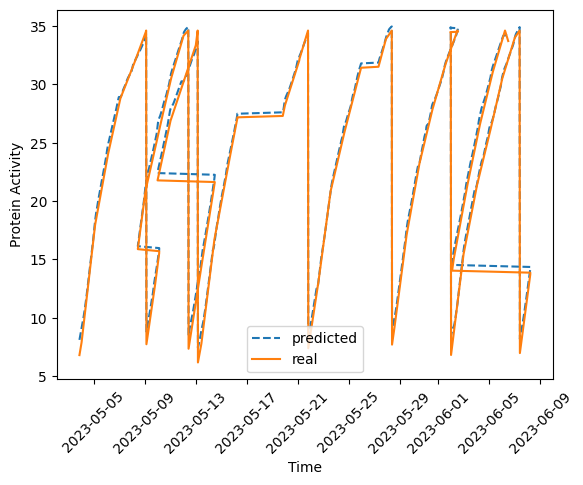

In [158]:
import matplotlib

dates = matplotlib.dates.date2num(test_data.TimeStamp.tolist())
plt.plot_date(dates[:len(predictions_descaled)], predictions_descaled, "--", label="predicted")
plt.plot_date(dates[:len(labels_descaled)], labels_descaled, "-", label="real")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Protein Activity")
plt.legend()